# GPS Data Preprocessing
This notebook preprocesses a GPS dataset by handling missing values and outliers, preparing it for downstream machine learning tasks.

## Dataset Overview
- **Columns**:
  - `Date`: Travel date
  - `StartTime`: Departure time
  - `DayOfWeek`: Day of the week
  - `GoingTo`: Destination (work/home)
  - `Distance`: Distance traveled (km)
  - `MaxSpeed`: Max speed (km/h)
  - `AvgSpeed`: Average speed (km/h)
  - `AvgMovingSpeed`: Average moving speed (km/h)
  - `FuelEconomy`: Fuel consumption
  - `TotalTime`: Total travel time (min)
  - `MovingTime`: Moving time (min)
  - `Toll`: Toll road usage (Yes/No)

In [3]:
# Import libraries
import numpy as np
import pandas as pd
from lightgbm import LGBMRegressor
from catboost import CatBoostClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

In [4]:
# Load dataset
data_path = Path('travel_times.csv')
df = pd.read_csv(data_path)
df.head()

,Date,StartTime,DayOfWeek,GoingTo,Distance,MaxSpeed,AvgSpeed,AvgMovingSpeed,FuelEconomy,TotalTime,MovingTime,Toll,Comments
0,1/6/2012,16:37,Friday,home,51.29,127.4,78.3,84.8,NaN,39.3,36.3,No,NaN
1,1/6/2012,8:20,Friday,work,51.63,130.3,81.8,88.9,NaN,37.9,34.9,No,NaN
2,1/4/2012,16:17,Wednesday,home,51.27,1207.4,82.0,NaN,NaN,NaN,35.9,No,NaN
3,1/4/2012,7:53,Wednesday,work,49.17,132.3,74.2,82.9,NaN,39.8,35.6,NaN,NaN
4,1/3/2012,18:57,Tuesday,home,51.15,136.2,83.4,88.1,NaN,36.8,34.8,NaN,NaN


In [ ]:
# Initial inspection
df.info()

In [5]:
# Drop 'Comments' due to high missing rate
df = df.drop(columns=['Comments'])

In [6]:
# Fill missing 'FuelEconomy' and 'AvgMovingSpeed' with rounded means
fuel_mean = df['FuelEconomy'].mean().round(2)
moving_speed_mean = df['AvgMovingSpeed'].mean().round(2)
df['FuelEconomy'] = df['FuelEconomy'].fillna(fuel_mean)
df['AvgMovingSpeed'] = df['AvgMovingSpeed'].fillna(moving_speed_mean)

In [7]:
# Predict missing 'TotalTime' with LightGBM
x_train = df.dropna(subset=['TotalTime']).drop(columns=['TotalTime'])
y_train = df.dropna(subset=['TotalTime'])['TotalTime']
x_test = df[df['TotalTime'].isna()].drop(columns=['TotalTime'])

# Encode categorical columns
cat_cols = x_train.select_dtypes(include=['object']).columns
for col in cat_cols:
    x_train[col] = x_train[col].astype('category').cat.codes
    x_test[col] = x_test[col].astype('category').cat.codes

# Train LightGBM regressor
lgbm = LGBMRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42, verbose=-1)
lgbm.fit(x_train, y_train)
df.loc[df['TotalTime'].isna(), 'TotalTime'] = lgbm.predict(x_test)

In [8]:
# Predict missing 'Toll' with CatBoost
x_train = df.dropna(subset=['Toll']).drop(columns=['Toll'])
y_train = df.dropna(subset=['Toll'])['Toll']
x_test = df[df['Toll'].isna()].drop(columns=['Toll'])

# CatBoost handles categorical features natively
cat_cols = x_train.select_dtypes(include=['object']).columns.tolist()
cb = CatBoostClassifier(iterations=100, learning_rate=0.1, depth=5, random_seed=42, verbose=0)
cb.fit(x_train, y_train, cat_features=cat_cols)
df.loc[df['Toll'].isna(), 'Toll'] = cb.predict(x_test)

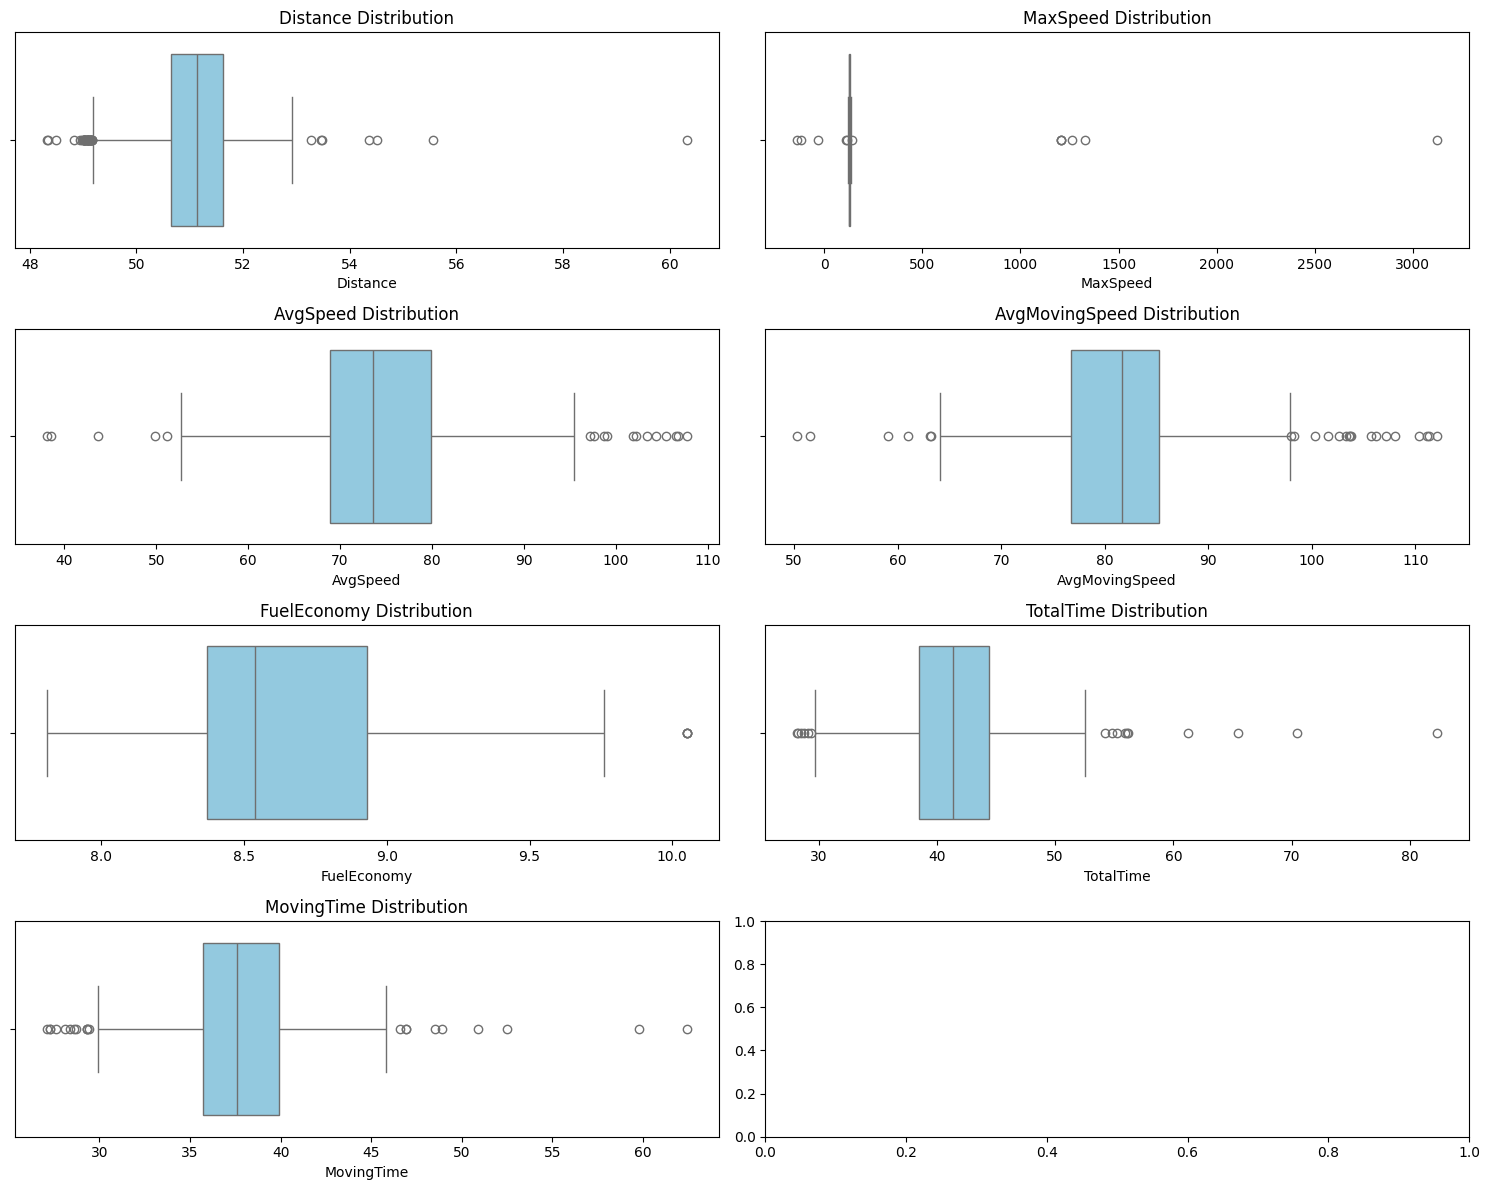

In [9]:
# Visualize numerical columns
num_cols = ['Distance', 'MaxSpeed', 'AvgSpeed', 'AvgMovingSpeed', 'FuelEconomy', 'TotalTime', 'MovingTime']
fig, axes = plt.subplots(4, 2, figsize=(15, 12))
axes = axes.flatten()
for i, col in enumerate(num_cols):
    sns.boxplot(x=df[col], ax=axes[i], color='skyblue')
    axes[i].set_title(f'{col} Distribution')
plt.tight_layout()
plt.show()

In [10]:
# Handle outliers in 'MaxSpeed' using IQR
Q1, Q3 = np.percentile(df['MaxSpeed'], [25, 75])
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Extract outliers
outlier_speed = sorted(df[(df['MaxSpeed'] < lower_bound) | (df['MaxSpeed'] > upper_bound)]['MaxSpeed'].tolist())

# Replace outliers with mean of non-outliers
mean_speed = df[(df['MaxSpeed'] >= lower_bound) & (df['MaxSpeed'] <= upper_bound)]['MaxSpeed'].mean().round(2)
df.loc[(df['MaxSpeed'] < lower_bound) | (df['MaxSpeed'] > upper_bound), 'MaxSpeed'] = mean_speed

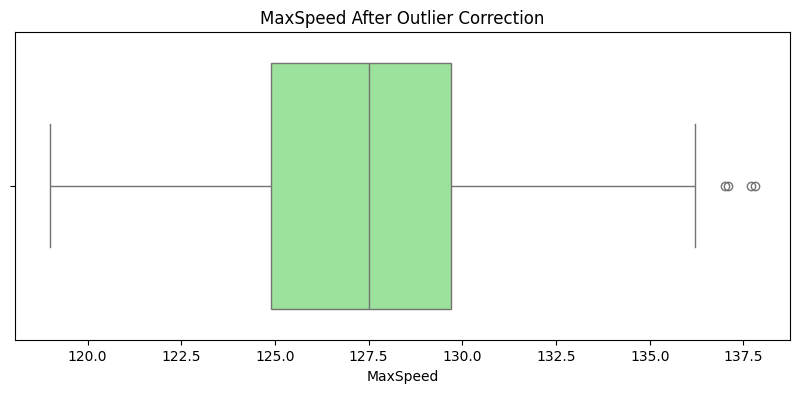

In [11]:
# Visualize updated 'MaxSpeed'
plt.figure(figsize=(10, 4))
sns.boxplot(x=df['MaxSpeed'], color='lightgreen')
plt.title('MaxSpeed After Outlier Correction')
plt.show()

In [ ]:
# Save outputs
output_dir = Path('outputs')
output_dir.mkdir(exist_ok=True)

np.savez(output_dir / 'answers.npz', outlier_speed=outlier_speed)
df.to_csv(output_dir / 'preprocessed_df.csv', index=True)

# Compress files
import zipfile
files = [output_dir / 'answers.npz', output_dir / 'preprocessed_df.csv', Path('data_processing.ipynb')]
with zipfile.ZipFile(output_dir / 'result.zip', 'w', compression=zipfile.ZIP_DEFLATED) as zf:
    for file in files:
        zf.write(file, file.name)